In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image
import requests
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Create data directory
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

# Download CIFAR-10 dataset (smaller alternative for quick testing)
# We'll use CIFAR-10 but treat it as 2-class problem for demonstration
print("Downloading CIFAR-10 dataset...")

# Define transformations for CIFAR-10 (smaller images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download CIFAR-10
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=data_transforms['val'])

# Convert to 2-class problem (classes 0-4 vs 5-9) for binary classification
def convert_to_binary(dataset):
    binary_data = []
    binary_targets = []
    for data, target in dataset:
        # Class 0: classes 0-4, Class 1: classes 5-9
        binary_target = 0 if target < 5 else 1
        binary_data.append(data)
        binary_targets.append(binary_target)
    return list(zip(binary_data, binary_targets))

# Apply binary conversion
train_dataset_binary = convert_to_binary(train_dataset)
val_dataset_binary = convert_to_binary(val_dataset)

class_names = ['Class 0-4', 'Class 5-9']  # Simplified class names

print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset_binary)}")
print(f"Validation samples: {len(val_dataset_binary)}")

# Create custom dataset class
class BinaryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset_final = BinaryDataset(train_dataset_binary)
val_dataset_final = BinaryDataset(val_dataset_binary)

Classes: ['Class 0-4', 'Class 5-9']
Training samples: 50000
Validation samples: 10000


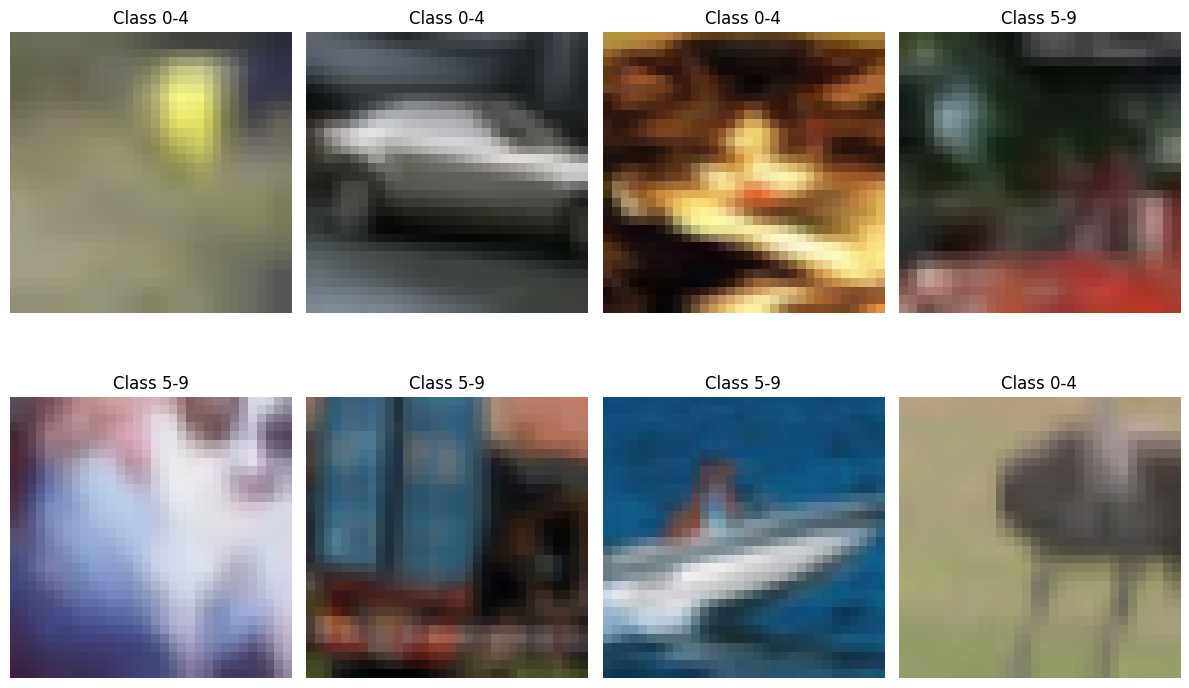

In [3]:
# Display sample images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Create data loaders for visualization
batch_size = 32
train_loader = DataLoader(train_dataset_final, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_final, batch_size=batch_size, shuffle=False)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch (adjust for smaller images)
plt.figure(figsize=(12, 8))
for i in range(min(8, batch_size)):
    plt.subplot(2, 4, i+1)
    imshow(inputs[i], title=class_names[classes[i]])
plt.tight_layout()
plt.show()

In [4]:
# Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer for smaller input size (32x32 instead of 224x224)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()  # Remove maxpool for smaller images

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 2 classes

print("Modified ResNet18 architecture:")
print(f"Input size adapted for 32x32 images")
print(f"Final FC layer output features: {len(class_names)}")

# Display model structure
print("\nModel architecture:")
print(model)

Modified ResNet18 architecture:
Input size adapted for 32x32 images
Final FC layer output features: 2

Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [5]:
# Freeze all layers initially
print("Freezing all layers...")
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
print("Unfreezing the final FC layer...")
for param in model.fc.parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the final layer

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Freezing all layers...
Unfreezing the final FC layer...

Trainable parameters:
  fc.weight
  fc.bias

Total parameters: 11,169,858
Trainable parameters: 1,026
Frozen parameters: 11,168,832
Using device: cpu


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    """
    Training function for the transfer learning model
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().item())
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
# Train the model
print("Starting training...")
num_epochs = 8

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

print("Training completed!")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")

Starting training...
Epoch 1/8
------------------------------------------------------------
Train Loss: 0.6929 Acc: 0.5717
Val Loss: 0.7200 Acc: 0.5645

Epoch 2/8
------------------------------------------------------------
Train Loss: 0.6823 Acc: 0.5840
Val Loss: 0.6638 Acc: 0.6106

Epoch 3/8
------------------------------------------------------------
Train Loss: 0.6834 Acc: 0.5811
Val Loss: 0.6565 Acc: 0.6231

Epoch 4/8
------------------------------------------------------------
Train Loss: 0.6844 Acc: 0.5841
Val Loss: 0.6540 Acc: 0.6173

Epoch 5/8
------------------------------------------------------------
Train Loss: 0.6853 Acc: 0.5802
Val Loss: 0.6570 Acc: 0.6154

Epoch 6/8
------------------------------------------------------------
Train Loss: 0.6630 Acc: 0.5977
Val Loss: 0.6479 Acc: 0.6228

Epoch 7/8
------------------------------------------------------------
Train Loss: 0.6597 Acc: 0.6008
Val Loss: 0.6485 Acc: 0.6200

Epoch 8/8
---------------------------------------------

Evaluating model on validation set...
Final Validation Accuracy: 0.6217


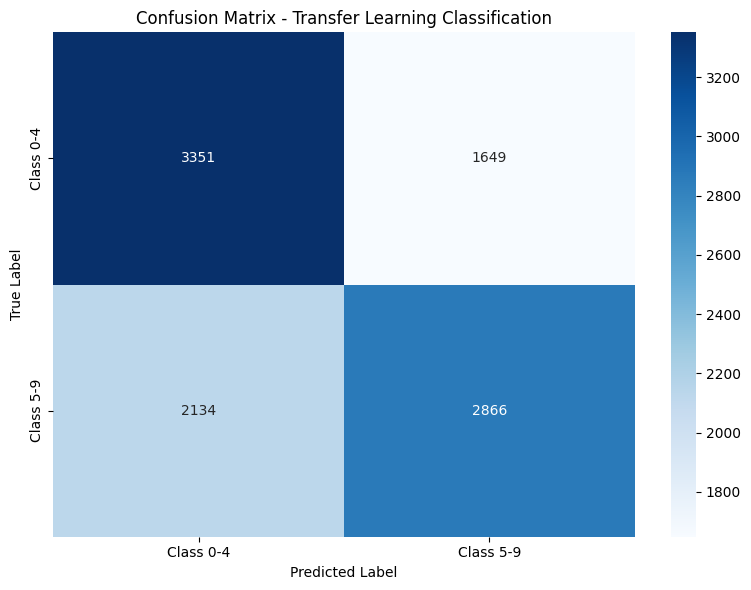


Classification Report:
              precision    recall  f1-score   support

   Class 0-4       0.61      0.67      0.64      5000
   Class 5-9       0.63      0.57      0.60      5000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



In [19]:
def evaluate_model(model, dataloader):
    """
    Evaluate the model and return predictions and true labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Evaluate on validation set
print("Evaluating model on validation set...")
val_preds, val_labels = evaluate_model(model, val_loader)

# Calculate accuracy
val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels))
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Transfer Learning Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names))

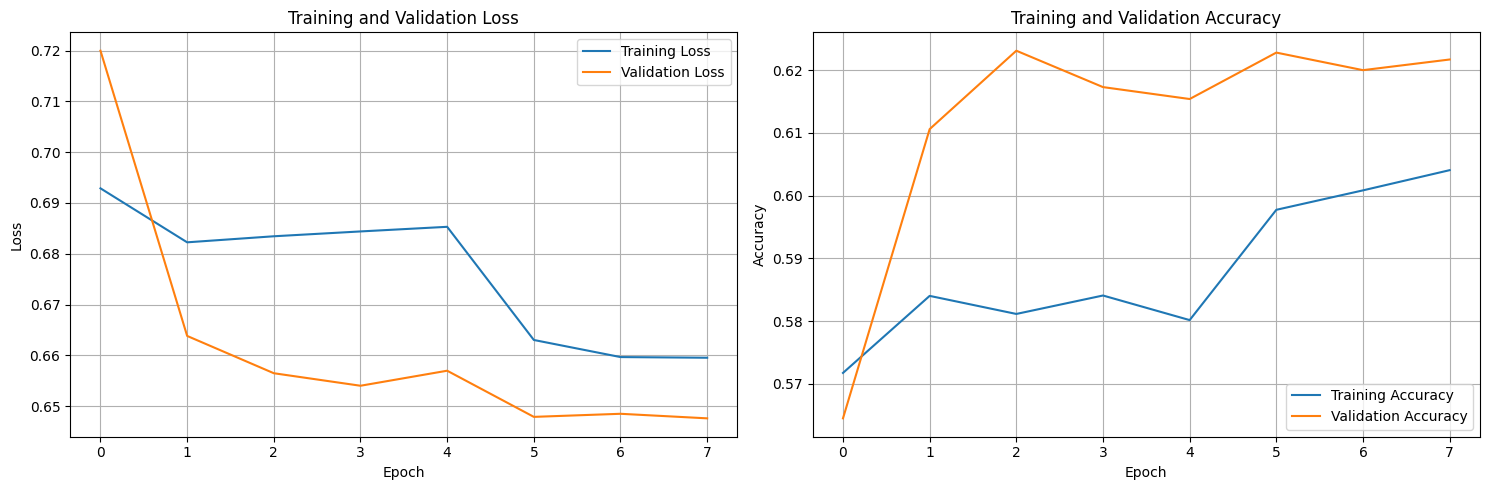

In [21]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Save the trained model
torch.save(model.state_dict(), 'resnet18_transfer_learning.pth')
print("Model saved as 'resnet18_transfer_learning.pth'")

# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

import json
with open('training_history.json', 'w') as f:
    json.dump(history, f)
print("Training history saved as 'training_history.json'")

# Print final summary
print("\n" + "="*50)
print("TRANSFER LEARNING SUMMARY")
print("="*50)
print(f"Dataset: CIFAR-10 (converted to binary classification)")
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset_final)}")
print(f"Validation samples: {len(val_dataset_final)}")
print(f"Model: ResNet18 (pretrained on ImageNet)")
print(f"Frozen layers: All except final FC layer")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Final validation accuracy: {val_accuracy:.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")
print("="*50)

Model saved as 'resnet18_transfer_learning.pth'
Training history saved as 'training_history.json'

TRANSFER LEARNING SUMMARY
Dataset: CIFAR-10 (converted to binary classification)
Classes: ['Class 0-4', 'Class 5-9']
Training samples: 50000
Validation samples: 10000
Model: ResNet18 (pretrained on ImageNet)
Frozen layers: All except final FC layer
Trainable parameters: 1,026
Final validation accuracy: 0.6217
Best validation accuracy: 0.6231
